In [1]:
## modify these parameters
fname = 'data/3_9eq_03_02_2022_-25_005.mp4'

# set to -1 to store one image per minute
store_every = -1
store_every = 100

# set to -1 to read all of the images
max_images_to_read = -1
max_images_to_read = 10000

In [2]:
## don't modify below here, just execute

In [3]:
!pwd

/Users/ericdill/dev/jdm/liquid-crystal


In [4]:
import pathlib
fname = pathlib.Path(fname)
if not fname.exists():
    raise RuntimeError(f"Cannot find {fname}")

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
import textwrap
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import traitlets

import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
from ipywidgets import interactive
import datetime

In [6]:
%matplotlib inline

In [7]:
class VideoData(traitlets.HasTraits):
    filename = traitlets.Any()
    # Store every how many frames?
    store_every = traitlets.Integer(default_value=-1)
    # How many images should we ready into memory?
    max_images_to_read = traitlets.Integer(default_value=-1)
    
    # parameters automatically managed by the class, don't set
    _vid = traitlets.Any()
    # _data = traitlets.Any()
    _fps = traitlets.Float()
    _frame_count = traitlets.Integer()
    _duration = traitlets.Float()
    _width = traitlets.Integer()
    _height = traitlets.Integer()
    _images_to_store = traitlets.Integer()
    _time_between_stored_images = traitlets.Float()
    
    def __init__(self):
        # write up interactivity
        self.observe(self._new_params)
        self._data = None
    
    def _parse_vid_metadata(self):
        if self._vid is None:
            return
        self._fps = self._vid.get(cv2.CAP_PROP_FPS)
        self._frame_count = int(self._vid.get(cv2.CAP_PROP_FRAME_COUNT))
        self._duration = self._frame_count/self._fps
        self._width = int(self._vid.get(cv2.CAP_PROP_FRAME_WIDTH))
        self._height = int(self._vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        if self.store_every == -1:
            self.store_every = int(np.ceil(self._fps))
        if self.max_images_to_read == -1:
            self.max_images_to_read = self._frame_count
        
        self._images_to_store = self.max_images_to_read // self.store_every
        self._time_between_stored_images = self.store_every / self._fps
    
    def md(self):
        all_traits = self.traits()
        del all_traits['_vid']
        d = {k: getattr(self, k) for k, v in all_traits.items()}
        return d
    
    def _init_data(self):
        self._data = np.zeros((self._images_to_store+1, self._height, self._width), dtype=np.uint8)
        
    def _new_params(self, update):
        print(update)
        if update['name'] == 'filename':
            self._vid = cv2.VideoCapture(str(self.filename))
        if update['name'] in ('_vid', 'store_every', 'max_images_to_read'):
            # parse the video metadata
            self._parse_vid_metadata()
            self._init_data()
            
    def total_time(self):
        seconds=int(self._frame_count / self._fps)
        total_time = str(datetime.timedelta(seconds=seconds))
        return seconds, f"Movie duration: {total_time} (HH:MM:SS)"

    def index_metadata(self, idx):
        seconds = idx * self.store_every / self._fps
        dt = str(datetime.timedelta(seconds=seconds))
        index = idx * self.store_every
        return {'image_timestamp': dt, 'actual_image_index': index}

    def read(self):
        """Read in video frames up to `self.max_images_to_read` but only save every `self.store_every` in memory"""
        print(f"Reading in {self.max_images_to_read} and storing one frame every {self.store_every} frames. "
              f"This corresponds to one frame every {self._time_between_stored_images} second(s) "
              f"and {self._data.shape[0]} images will be stored in total.")
        for idx in trange(self.max_images_to_read-1):
            ret, frame = self._vid.read()
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            if not ret:
                # no more frames to read
                break
            if idx % self.store_every == 0:
                self._data[idx // self.store_every] = gray
            
        

In [16]:
v = VideoData()

In [17]:
v.store_every = 100
v.max_images_to_read = 10000

{'name': 'store_every', 'old': -1, 'new': 100, 'owner': <__main__.VideoData object at 0x152386890>, 'type': 'change'}
{'name': 'max_images_to_read', 'old': -1, 'new': 10000, 'owner': <__main__.VideoData object at 0x152386890>, 'type': 'change'}


In [18]:
v.filename = fname

{'name': 'filename', 'old': None, 'new': PosixPath('data/3_9eq_03_02_2022_-25_005.mp4'), 'owner': <__main__.VideoData object at 0x152386890>, 'type': 'change'}
{'name': '_vid', 'old': None, 'new': < cv2.VideoCapture 0x1522bf590>, 'owner': <__main__.VideoData object at 0x152386890>, 'type': 'change'}
{'name': '_fps', 'old': 0.0, 'new': 13.12227601566946, 'owner': <__main__.VideoData object at 0x152386890>, 'type': 'change'}
{'name': '_frame_count', 'old': 0, 'new': 24780, 'owner': <__main__.VideoData object at 0x152386890>, 'type': 'change'}
{'name': '_duration', 'old': 0.0, 'new': 1888.3919199999998, 'owner': <__main__.VideoData object at 0x152386890>, 'type': 'change'}
{'name': '_width', 'old': 0, 'new': 1920, 'owner': <__main__.VideoData object at 0x152386890>, 'type': 'change'}
{'name': '_height', 'old': 0, 'new': 1200, 'owner': <__main__.VideoData object at 0x152386890>, 'type': 'change'}
{'name': '_images_to_store', 'old': 0, 'new': 100, 'owner': <__main__.VideoData object at 0x15

In [19]:
v.index_metadata(1), v.index_metadata(10)

({'image_timestamp': '0:00:07.620629', 'actual_image_index': 100},
 {'image_timestamp': '0:01:16.206292', 'actual_image_index': 1000})

In [20]:
v.read()

Reading in 10000 and storing one frame every 100 frames. This corresponds to one frame every 7.620629217110572 second(s) and 101 images will be stored in total.


  0%|          | 0/9999 [00:00<?, ?it/s]

Text(0, 0.5, 'total image intensity')

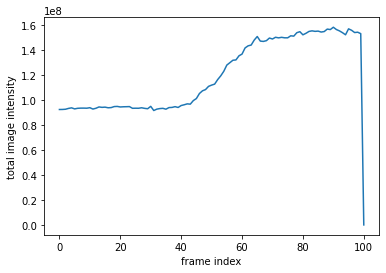

In [21]:
## Plot summed intensity over time
I = np.sum(v._data, axis=(1,2))
fig, ax = plt.subplots()
lines = ax.plot(I)
ax.set_xlabel("frame index")
ax.set_ylabel("total image intensity")

In [22]:
%matplotlib widget

In [23]:
v.md()

{'_duration': 1888.3919199999998,
 '_fps': 13.12227601566946,
 '_frame_count': 24780,
 '_height': 1200,
 '_images_to_store': 100,
 '_time_between_stored_images': 7.620629217110572,
 '_width': 1920,
 'filename': PosixPath('data/3_9eq_03_02_2022_-25_005.mp4'),
 'max_images_to_read': 10000,
 'store_every': 100}

In [94]:
def imshow_with_patches(ax, data, patches: dict):
    try:
        im = ax.images[-1]
    except IndexError:
        print("No image currently show. calling ax.imshow")
        im = ax.imshow(data)
    else:
        im.set_data(data)
    
    print(f"Removing {len(ax.patches)} existing patches")
    
    for existing_patch in ax.patches:
        existing_patch.remove()
    added_patches = {}
    for patch_name, patch in patches.items():
        print(f"Adding patch for {patch_name}")
        added_patches[patch_name] = ax.add_patch(patch)
    return im, added_patches
    
class VideoScrubber(traitlets.HasTraits):
    video_data = traitlets.Any()
    
    def __init__(self):
        self.slider = widgets.IntSlider()
        self.timestamp = widgets.Text(description="HH:MM:SS")
        self.actual_frame = widgets.Text(description="actual frame")
        self.plot = widgets.Output()
        # Init the matplotlib plot
        self.fig, self.ax = plt.subplots()
        self.patches = {}
        
        # Define the layout
        with self.plot:
            plt.show(self.fig)

        # interactive_plot = interactive(self._plotter, idx=self.slider)
        # interact(self._plotter, frame_idx=self.slider)
        
        self.layout = widgets.VBox([
            self.slider,
            self.plot,
            self.timestamp, 
            self.actual_frame,
        ])
        
        # display(self.layout)
        
        # wire up interactivity
        
        self.observe(self._updater_callback)
        self.slider.observe(self._plotter_callback, names=['value'])
        
    
    def _update_plot(self, frame_idx):
        if self.video_data is None:
            return
        print(frame_idx)
        # return
        data = self.video_data._data[frame_idx]
        imshow_with_patches(self.ax, data, self.patches)
        # Get previous zoom
        self.fig.canvas.draw_idle()
        md = v.index_metadata(frame_idx)
        self.timestamp.value = md['image_timestamp']
        self.actual_frame.value = str(md['actual_image_index'])
        #TODO Update other text boxes
    
    def _draw_patches(self):
        patches = self.patches
        frame_idx = self.slider.value
        self._update_plot(frame_idx)
        
    def _plotter_callback(self, update):
        frame_idx = update['new']
        self._update_plot(frame_idx)
        
    def _updater_callback(self, update):
        print(update)
        if update['name'] == 'video_data':
            md = self.video_data.md()
            print(md)
            

In [96]:
vs = VideoScrubber()
vs.video_data = v

display(vs.layout)


{'name': 'video_data', 'old': None, 'new': <__main__.VideoData object at 0x152386890>, 'owner': <__main__.VideoScrubber object at 0x1563d1120>, 'type': 'change'}
{'_duration': 1888.3919199999998, '_fps': 13.12227601566946, '_frame_count': 24780, '_height': 1200, '_images_to_store': 100, '_time_between_stored_images': 7.620629217110572, '_width': 1920, 'filename': PosixPath('data/3_9eq_03_02_2022_-25_005.mp4'), 'max_images_to_read': 10000, 'store_every': 100}


In [101]:
import ipywidgets

In [97]:
import some_math

In [256]:
import importlib
importlib.reload(some_math)
import some_math

In [257]:
class UI(traitlets.HasTraits):
    frame_idx = traitlets.Integer()
    # video_data = traitlets.Any()
    lines = traitlets.List()
    
    def __init__(self):
        self.add_line_button = widgets.Button(description="Add Line")
        self.textbox = widgets.Text(description="HH:MM:SS")
        self.actual_frame = widgets.Text(description="actual frame")
        self.video_scrubber = VideoScrubber()
        self.plot = widgets.Output()
        self.slider = widgets.IntSlider()
        self.line_patches = {}
        
        # Wire up interactivity
        self.add_line_button.on_click(self._on_click)
        # self.observe(self._new_data, names=['video_data'])
        
        # Do the displaying stuff
        self.line_layout = widgets.VBox([self.add_line_button])
        with self.plot:
            plt.show(self.fig)
            
        self.layout = widgets.HBox([
            self.video_scrubber.layout,
            self.line_layout,
        ])
        display(self.layout)
        
        
    def _on_click(self, b):
        print(b)
        lf = some_math.LinearFace()
        lf.callback=self._update_line_data_callback
        self.lines.append(lf)
        self.line_layout.children = [_.layout for _ in self.lines] + [self.add_line_button]
        
    # def _new_data(self, data):
    #     print(data)
    #     print(self.video_data)
    #     self.ax.imshow(self.video_data._data[0])
    #     self.fig.canvas.draw()
        
    def _update_line_data_callback(self, obj):
        print(f'received update for {obj.name}')
        x0,y0 = obj.p1.x, obj.p1.y
        width = float(obj.width.value)
        height = float(obj.height.value)
        color = obj.color_picker.value
        th_deg = obj.rect_angle
        print(f'rectangle info: x0={x0},y0={y0},width={width},height={height},th_deg={th_deg},color={color}')
        patch = some_math.mpl_rect_patch(
            x=x0, y=y0, width=width, height=height, color=color,
            axes=self.video_scrubber.ax, rot=th_deg
        )
        self.line_patches[obj.name.value] = patch
        self.video_scrubber.patches = self.line_patches
        self.video_scrubber._draw_patches()
        
        
        

ui = UI()
ui.video_scrubber.video_data = v

{'name': 'video_data', 'old': None, 'new': <__main__.VideoData object at 0x152386890>, 'owner': <__main__.VideoScrubber object at 0x280699960>, 'type': 'change'}
{'_duration': 1888.3919199999998, '_fps': 13.12227601566946, '_frame_count': 24780, '_height': 1200, '_images_to_store': 100, '_time_between_stored_images': 7.620629217110572, '_width': 1920, 'filename': PosixPath('data/3_9eq_03_02_2022_-25_005.mp4'), 'max_images_to_read': 10000, 'store_every': 100}


In [30]:
ui.line_patches

{}

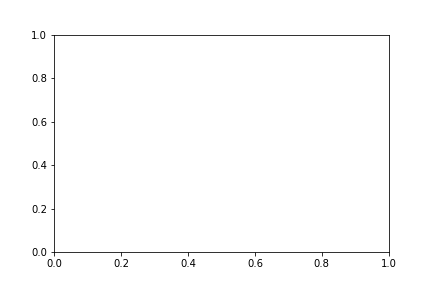

In [ ]:
fig, ax = plt.subplots()

In [ ]:
ax.imshow(ui.video_scrubber.video_data._data[0])
fig.canvas.draw()

In [ ]:
patch.remove()

In [114]:
x1,y1 = (500,500)
w,h = (100,100)
th2 = 0
patch2 = patches.Rectangle((x1,y1), w,h, color='red', alpha=0.5)
t2 = mpl.transforms.Affine2D().rotate_deg_around(x1,y1,th2) + ax.transData
patch2.set_transform(t2)
ax.add_patch(patch2)
fig.canvas.draw()

In [113]:
patch2.remove()

In [110]:
patch = ui.line_patches['bowed amine']
ax.add_patch(patch)
fig.canvas.draw()

In [158]:
ui = UI()

In [159]:
ui.video_data = v

{'name': 'video_data', 'old': None, 'new': <__main__.VideoData object at 0x7fe8d70f3bb0>, 'owner': <__main__.UI object at 0x7fe8daf63220>, 'type': 'change'}


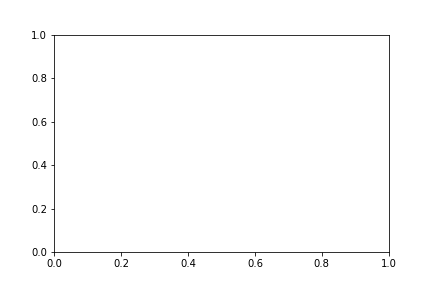

In [204]:
fig, ax = plt.subplots()

In [210]:
def make_patch(x,y,w,h,th,color, ax):
    patch = patches.Rectangle((x,y), w,h, color=color, alpha=0.5)
    transform = mpl.transforms.Affine2D().rotate_deg_around(x1,y1,th2) + ax.transData
    patch.set_transform(transform)
    return patch
    

In [194]:
import string
import random

In [195]:
opts = string.ascii_lowercase[:6] + string.digits

color = lambda: f"#{''.join(random.choices(opts, k=6))}"

In [196]:
color()

'#8e0720'

In [222]:
x1,y1 = (900,900)
w,h = (100,100)
th2 = 45
patch = make_patch(x1,y1,w,h,th2,color(), ax)
ax.add_patch(patch)
fig.canvas.draw()

In [198]:
fig.canvas.draw()

In [206]:
for p in ax.patches:
    p.remove()
fig.canvas.draw()

In [205]:
ax.imshow(v._data[-4])

In [208]:
patch.remove()

In [221]:
im = ax.images[-1]
im.set_data(v._data[50])
fig.canvas.draw()

In [209]:

ax.add_patch(patch)
fig.canvas.draw()